In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

seed_everything()


In [2]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4515, 0.4711, 0.4367],
                         std=[0.2504, 0.2435, 0.2782])
])

train_data = ImageFolder(root='Data', transform=transform)

print(train_data.classes)


['01_asphalt(Good)', '02_asphalt(Regular)', '03_asphalt(Bad)', '05_paved(Regular)', '06_paved(Bad)', '07_unpaved(Regular)', '08_unpaved(Bad)']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

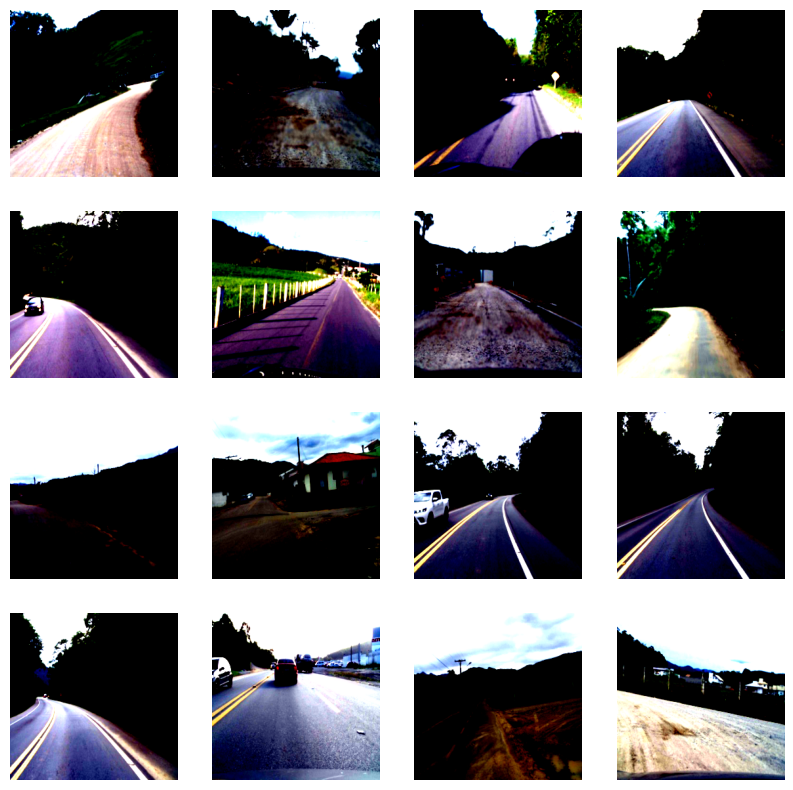

In [3]:
# show batch of images

def show_batch(data, n=4):
    fig, ax = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            ax[i, j].imshow(np.transpose(
                data[np.random.randint(len(data))][0], (1, 2, 0)))
            ax[i, j].axis('off')
    plt.show()


show_batch(train_data, n=4)


Model and Parameters

In [4]:
from model import ConvNeuralNet
import torch.nn as nn

# Define relevant variables for the ML task
batch_size = 64
num_classes = len(train_data.classes)
learning_rate = 0.001
num_epochs = 10
checkpoint_path = 'checkpoint/checkpoint.pth'

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNeuralNet(num_classes)
model = model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)


Training

In [5]:
best_loss = float("inf")
train_steps = len(train_data) // batch_size

# set the model in training mode
model.train()
for epoch in tqdm(range(num_epochs)):
    # initialize the total training and validation loss
    totalTrainLoss = 0

    # initialize the number of correct predictions in the training
    trainCorrect = 0
    
    # Load in the data in batches using the train_loader object
    for images, labels in train_loader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (outputs.argmax(1) ==
                         labels).type(torch.float).sum().item()

    # END OF EPOCH LOOP

    avgTrainLoss = totalTrainLoss / train_steps
    trainCorrect /= len(train_data)
    
    print('Epoch [{}/{}], Loss: {:.6f}, Accuracy: {:.6f}%'
          .format(epoch + 1,
                  num_epochs,
                  avgTrainLoss,
                  trainCorrect * 100))

    if avgTrainLoss < best_loss:
        best_loss = avgTrainLoss
        torch.save(model.state_dict(), checkpoint_path)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.232626, Accuracy: 64.391769%
Epoch [2/10], Loss: 0.239194, Accuracy: 92.445949%
Epoch [3/10], Loss: 0.087327, Accuracy: 97.629591%
Epoch [4/10], Loss: 0.038637, Accuracy: 98.984110%
Epoch [5/10], Loss: 0.026780, Accuracy: 99.088304%
Epoch [6/10], Loss: 0.027616, Accuracy: 99.244595%
Epoch [7/10], Loss: 0.024326, Accuracy: 99.426934%
Epoch [8/10], Loss: 0.022417, Accuracy: 99.374837%
Epoch [9/10], Loss: 0.015930, Accuracy: 99.661370%
Epoch [10/10], Loss: 0.015899, Accuracy: 99.531128%


Testing

In [6]:
test_data = ImageFolder(root='Test', transform=transform)
test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)
val_steps = len(test_data) // batch_size

model = ConvNeuralNet(num_classes)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

totalValLoss = 0
valCorrect = 0

with torch.no_grad():
    # set the model in evaluation mode
    model.eval()

    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        totalValLoss += criterion(outputs, labels)

        # calculate the number of correct predictions
        valCorrect += (outputs.argmax(1) ==
                       labels).type(torch.float).sum().item()

avgValLoss = totalValLoss / val_steps
valCorrect /= len(test_data)

print('Train Loss: {:.4f}, Accuracy: {:.2f}%'
      .format(avgValLoss,
              valCorrect * 100))


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.0646, Accuracy: 98.36%
